In [ ]:
!pip3 install networkx pyvis

   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 756.0/756.0 kB 5.3 MB/s eta 0:00:00


In [2]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
airports_df = pd.read_csv('Airports2.csv')

In [24]:
airports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


In [4]:
airports_df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [44]:
(airports_df['Origin_airport'] == airports_df['Destination_airport']).sum()

6517

we expect a directed graph with 6517 self loops

In [30]:
print(f"NaN values:\n"
      f"  Origin Latitude: {airports_df['Org_airport_lat'].isna().sum()}\n"
      f"  Destination Latitude: {airports_df['Dest_airport_lat'].isna().sum()}\n"
      f"  Origin Longitude: {airports_df['Org_airport_long'].isna().sum()}\n"
      f"  Destination Longitude: {airports_df['Dest_airport_long'].isna().sum()}")

NaN values:
  Origin Latitude: 6954
  Destination Latitude: 6807
  Origin Longitude: 6954
  Destination Longitude: 6807


Creating a directed graph using **Networkx** library, where:
- node $i \in V$ is an airport (of origin or destination) of the `airports_df` dataset
- there exists an edge $e_{i,j}$ between nodes $i$ and $j$ if and only if there exists a flight with `Origin_airport` $=i$ and `Destination_airport` $=j$.

We assign:
- to each node $i$ a location attribute (`latitude`, `longitude`);
- to edge $e_{i,j}$ a `passengers` attribute beeing the number of passengers of flight from airport $i$ to $j$ ;
- to edge $e_{i,j}$ a `flights` attribute beeing the number of flights from airport $i$ to $j$.

We will handle Nan values for latitude and longitude replacing them as *None*, because the nodes are still necessary to the creation of the network, but  will not appear in the final geographical map.

In [31]:
#Initializing an empty graph object
flight_net = nx.DiGraph()

# Creating the set of nodes: V
V = set(airports_df['Origin_airport']).union(airports_df['Destination_airport'])

#preparing locations (lat, long) to give as node attribute
airports= pd.concat([
    airports_df[['Origin_airport', 'Org_airport_lat', 'Org_airport_long']].rename(columns={
    'Origin_airport': 'Airport',
    'Org_airport_lat': 'Latitude',
    'Org_airport_long': 'Longitude'
    }),
    airports_df[['Destination_airport', 'Dest_airport_lat', 'Dest_airport_long']].drop_duplicates().rename(columns={
    'Destination_airport': 'Airport',
    'Dest_airport_lat': 'Latitude',
    'Dest_airport_long': 'Longitude'
    })
]).drop_duplicates().set_index('Airport')[['Latitude', 'Longitude']].to_dict('index')

#adding nodes with location as attribute
for v in V:
    if v in airports:
        lat, long = airports[v]['Latitude'], airports[v]['Longitude']
        flight_net.add_node(v, latitude = lat, longitude = long)

        #if Nan, assign "none" as a location
        if pd.isna(lat) or pd.isna(long):
            flight_net.add_node(v, latitude = 'none', longitude = 'none')
        else:
            flight_net.add_node(v, latitude = lat, longitude = long)

    else:
        flight_net.add_node(v) #if not in airports

#adding edges with #passengers and #flights as attributes:
for indx, row in airports_df.iterrows():
    flight_net.add_edge( row['Origin_airport'], row['Destination_airport'],
                        passengers = row['Passengers'],
                        flights = row['Flights']
                        )

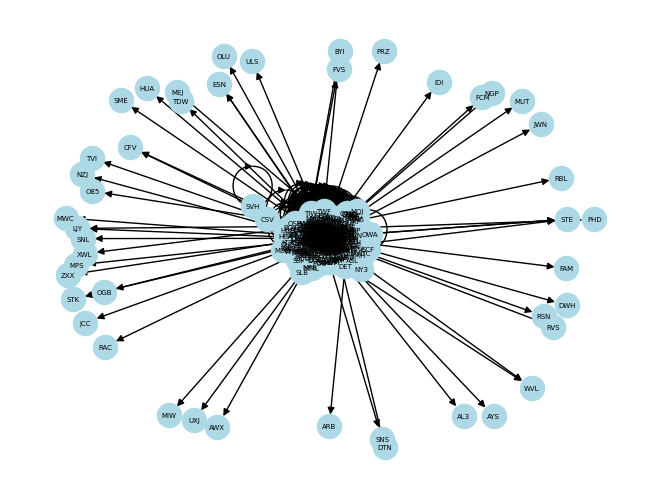

In [33]:
#static visualization
import matplotlib.pyplot as plt
nx.draw(flight_net, pos = nx.spring_layout(flight_net), with_labels=True,  node_color="lightblue", font_size=5)
plt.show()

The `analyze_graph_features` function from `functions.flight_net_analysis` analyzes a directed flight network graph by:

- Graph Properties: It calculates the number of nodes $N$ (airports), edges $E$ (flights), and density $D = \frac{E}{N^2}$ and classifies the graph as sparse, dense, or moderate based on density thresholds.

- Degree Analysis: It computes in-degree, out-degree, and degree for each node, visualizing the distributions with histograms.

- Hub Identification: It identifies airports with degrees higher than the 90th percentile and returns them as hubs in a DataFrame.

In [48]:
from functions.flight_net_analysis import analyze_graph_features

Number of nodes N = 727
Number of edges E= 36719
Density D = 0.06947395507152872

The graph is sparse (D < 0.1)


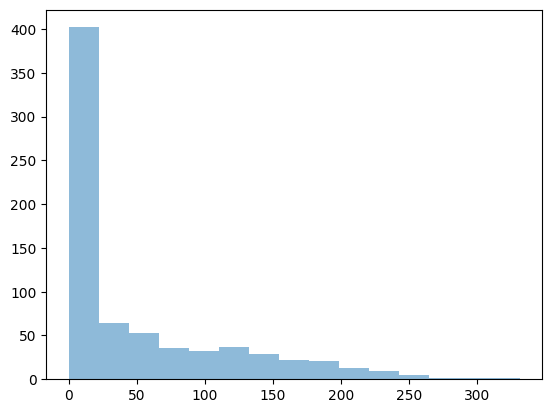

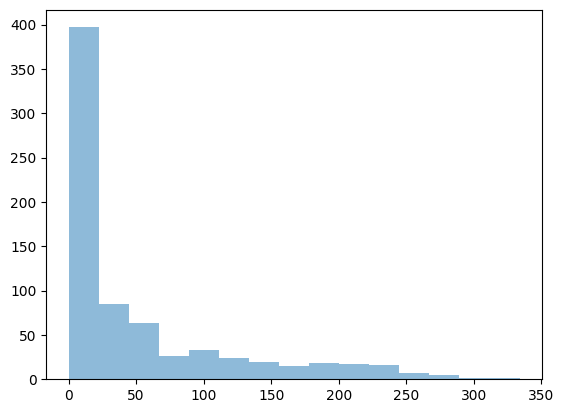

,Airport,Degree
0,IND,513
1,SLC,468
2,SAN,339
3,CLE,446
4,ICT,400
...,...,...
68,TUL,378
69,ATL,539
70,BUF,375
71,BDL,344


In [49]:
analyze_graph_features(flight_net)

In [53]:
import importlib
from functions import flight_net_analysis

# Now reload the module
importlib.reload(flight_net_analysis)

<module 'functions.flight_net_analysis' from 'c:\\Users\\Val\\Documents\\GitHub\\ADM_HM5\\functions\\flight_net_analysis.py'>

Number of nodes N = 727
Number of edges E = 36719
Density D = 0.06947395507152872
The graph is sparse (Density = 0.06947395507152872)


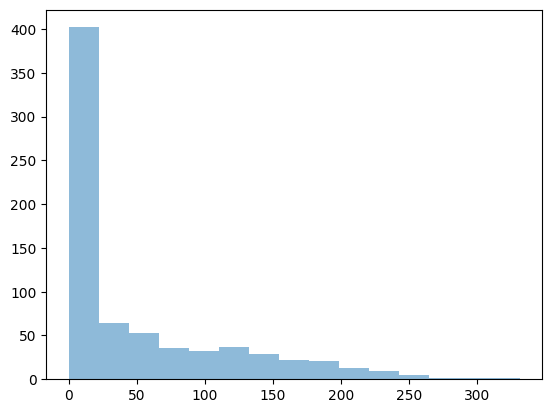

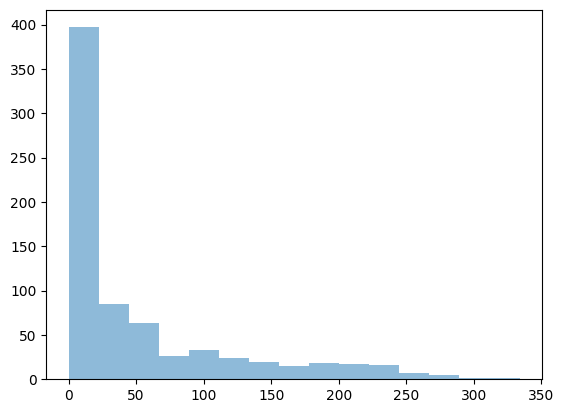


Hubs (airports with degree > 90th percentile):
   Airport  Degree
0      IND     513
1      SLC     468
2      SAN     339
3      CLE     446
4      ICT     400
..     ...     ...
68     TUL     378
69     ATL     539
70     BUF     375
71     BDL     344
72     MSP     583

[73 rows x 2 columns]


In [54]:
from functions import flight_net_analysis
from functions.flight_net_analysis import analyze_graph_features, summarize_graph_features
summarize_graph_features(flight_net)